In [ ]:
# step 1: config + imports
NORMAL_FILE = "telemetry_logs(DF005).csv"
FAULT_FILE  = "telemetry_gps_faulted_simple.csv"
OUT_DIR     = "pytorch_model_output"
import os, math, json
os.makedirs(OUT_DIR, exist_ok=True)

FEATURES = [
    "IMU_ATTI(0):Longitude",
    "IMU_ATTI(0):Latitude",
    "IMU_ATTI(0):alti:D",
    "IMU_ATTI(0):relativeHeight:C",
    "IMU_ATTI(0):numSats",
    "IMU_ATTI(0):roll:C",
    "IMU_ATTI(0):pitch:C",
    "IMU_ATTI(0):yaw:C",
    "IMU_ATTI(0):press:D"
]

# training hyperparameters
TIMESTEPS = 50
BATCH_SIZE = 64
EPOCHS = 80
LEARNING_RATE = 1e-3
PATIENCE = 10   # early stopping patience (epochs)
SEED = 42

# thresholding options
THRESHOLD_METHOD = "mean_std"  # or "percentile"
PERCENTILE = 99

# imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.pyplot as plt
# i used pytorch, wasn't able to run tensorflow on my pc
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(SEED)
np.random.seed(SEED)

print("Step 1 done: configuration and imports loaded.")


In [ ]:
# Step 2: load normal CSV and fit scaler(feature selection and normalization)
df_norm = pd.read_csv(NORMAL_FILE, low_memory=False)
missing = [c for c in FEATURES if c not in df_norm.columns]
if missing:
    raise RuntimeError(f"Missing required columns in normal file: {missing}")

# select features and handle NaNs (training uses normal data)
df_norm_sel = df_norm[FEATURES].copy()
if df_norm_sel.isna().any().any():
    print("Warning: NaNs found in normal data; filling with forward/back fill.")
    df_norm_sel = df_norm_sel.fillna(method='ffill').fillna(method='bfill').fillna(0.0)

# fit scaler only on normal data
scaler = MinMaxScaler()
scaled_norm = scaler.fit_transform(df_norm_sel.values)   # shape (N, d)
joblib.dump(scaler, os.path.join(OUT_DIR, "scaler.joblib"))
print("Scaler fitted and saved to:", os.path.join(OUT_DIR, "scaler.joblib"))
print("Step 2 done: normal data loaded and scaler fitted.")


In [ ]:
# Step 3: create sliding windows for training
def build_sequences(arr2d, timesteps):
    N = arr2d.shape[0]
    if N < timesteps + 1:
        raise RuntimeError(f"Not enough rows ({N}) to build windows of length {timesteps}")
    seqs = [arr2d[i:i+timesteps] for i in range(N - timesteps)]
    return np.array(seqs)

X_train = build_sequences(scaled_norm, TIMESTEPS)
print("X_train shape:", X_train.shape)  # (n_windows, TIMESTEPS, n_features)
print("Step 3 done: training sequences prepared.")


In [ ]:
# Step 4: Dataset and DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, windows):
        # windows: numpy array (n_samples, T, d)
        self.windows = torch.tensor(windows, dtype=torch.float32)
    def __len__(self):
        return self.windows.shape[0]
    def __getitem__(self, idx):
        return self.windows[idx], self.windows[idx]  # autoencoder: input==target

train_dataset = TimeSeriesDataset(X_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

print("Step 4 done: DataLoader ready (batches).")


In [ ]:
# Step 5: model definition
class LSTMAE(nn.Module):
    def __init__(self, n_features, hidden_dim1=128, hidden_dim2=64, timesteps=TIMESTEPS):
        super().__init__()
        self.encoder_l1 = nn.LSTM(input_size=n_features, hidden_size=hidden_dim1, batch_first=True)
        self.encoder_l2 = nn.LSTM(input_size=hidden_dim1, hidden_size=hidden_dim2, batch_first=True)
        self.repeat_len = timesteps
        # decoder
        self.decoder_l1 = nn.LSTM(input_size=hidden_dim2, hidden_size=hidden_dim2, batch_first=True)
        self.decoder_l2 = nn.LSTM(input_size=hidden_dim2, hidden_size=hidden_dim1, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim1, n_features)

    def forward(self, x):
        # x: (batch, T, d)
        out, _ = self.encoder_l1(x)           # out shape (batch, T, hidden_dim1)
        out, (h_n, c_n) = self.encoder_l2(out) # out is (batch, T, hidden_dim2) but final h_n is latent (1, batch, hidden_dim2)
        # take the last hidden state from encoder_l2 as latent representation
        latent = h_n[-1]                      # (batch, hidden_dim2)
        # repeat latent across timesteps
        repeated = latent.unsqueeze(1).repeat(1, self.repeat_len, 1)  # (batch, T, hidden_dim2)
        # decode
        out, _ = self.decoder_l1(repeated)
        out, _ = self.decoder_l2(out)
        # map to features per timestep
        out = self.output_layer(out)  # (batch, T, n_features)
        return out

n_features = X_train.shape[2]
model = LSTMAE(n_features, hidden_dim1=128, hidden_dim2=64, timesteps=TIMESTEPS)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)
print(model)
print("Step 5 done: model built and moved to device:", device)


In [ ]:
# Step 6: training loop with early stopping
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

best_val_loss = np.inf
patience_counter = 0
model_path = os.path.join(OUT_DIR, "pytorch_lstm_ae.pth")

# We'll use a small validation split from X_train (since we trained on normal only)
val_split = 0.2
n_windows = X_train.shape[0]
n_val = int(n_windows * val_split)
if n_val == 0:
    raise RuntimeError("Not enough windows for validation. Reduce TIMESTEPS or supply more data.")
# simple split: last n_val windows for val
train_idx = np.arange(0, n_windows - n_val)
val_idx = np.arange(n_windows - n_val, n_windows)
X_train_train = X_train[train_idx]
X_train_val = X_train[val_idx]

train_dataset = TimeSeriesDataset(X_train_train)
val_dataset = TimeSeriesDataset(X_train_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

for epoch in range(1, EPOCHS+1):
    model.train()
    train_losses = []
    for xb, _ in train_loader:
        xb = xb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, xb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = np.mean(train_losses)

    # validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, _ in val_loader:
            xb = xb.to(device)
            out = model(xb)
            loss = criterion(out, xb)
            val_losses.append(loss.item())
    val_loss = np.mean(val_losses)

    print(f"Epoch {epoch}  train_loss={train_loss:.6e}  val_loss={val_loss:.6e}")

    # early stopping logic
    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_path)
        patience_counter = 0
        print("  saved best model.")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

# load best model
model.load_state_dict(torch.load(model_path, map_location=device))
print("Step 6 done: training complete, best model loaded from:", model_path)


Epoch 1  train_loss=1.019675e-01  val_loss=8.086679e-02
  saved best model.
Epoch 2  train_loss=3.150423e-02  val_loss=2.908982e-02
  saved best model.
Epoch 3  train_loss=1.553797e-02  val_loss=3.092373e-02
Epoch 4  train_loss=9.989374e-03  val_loss=2.269940e-02
  saved best model.
Epoch 5  train_loss=8.136384e-03  val_loss=2.250417e-02
  saved best model.
Epoch 6  train_loss=6.607164e-03  val_loss=2.051827e-02
  saved best model.
Epoch 7  train_loss=5.850006e-03  val_loss=1.629484e-02
  saved best model.
Epoch 8  train_loss=5.114415e-03  val_loss=2.009562e-02
Epoch 9  train_loss=5.278002e-03  val_loss=1.553971e-02
  saved best model.
Epoch 10  train_loss=4.469267e-03  val_loss=1.508746e-02
  saved best model.
Epoch 11  train_loss=4.191570e-03  val_loss=1.549791e-02
Epoch 12  train_loss=4.035214e-03  val_loss=1.439337e-02
  saved best model.
Epoch 13  train_loss=3.862450e-03  val_loss=1.492244e-02
Epoch 14  train_loss=3.681186e-03  val_loss=1.479349e-02
Epoch 15  train_loss=3.599998e-

In [ ]:
# Step 7: reconstruction error on training windows -> threshold
model.eval()
def compute_window_mse(model, data_array):
    # data_array: numpy (n_windows, T, d)
    ds = TimeSeriesDataset(data_array)
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False)
    mses = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(device)
            out = model(xb)
            mse_batch = torch.mean((xb - out)**2, dim=[1,2]).cpu().numpy()  # per sample
            mses.extend(mse_batch.tolist())
    return np.array(mses)

# recompute using full training windows (X_train)
mse_train = compute_window_mse(model, X_train)
if THRESHOLD_METHOD == "mean_std":
    mean_m = mse_train.mean(); std_m = mse_train.std()
    threshold = mean_m + 3*std_m
else:
    threshold = np.percentile(mse_train, PERCENTILE)

stats = {"threshold": float(threshold), "mse_mean": float(mse_train.mean()), "mse_std": float(mse_train.std())}
with open(os.path.join(OUT_DIR, "threshold_stats.json"), "w") as f:
    json.dump(stats, f)
print("Threshold computed and saved:", stats)
print("Step 7 done.")


Threshold computed and saved: {'threshold': 0.023444104743268843, 'mse_mean': 0.0044435536333828065, 'mse_std': 0.006333517036628678}
Step 7 done.


In [ ]:
# Step 8: load fault file and scale using training scaler
df_fault = pd.read_csv(FAULT_FILE, low_memory=False)
missing_f = [c for c in FEATURES if c not in df_fault.columns]
if missing_f:
    raise RuntimeError(f"Missing required features in fault file: {missing_f}")

# keep original NaN mask for reporting outage rows
nan_mask = df_fault[FEATURES].isna()

# fill NaNs (forward/back) so windows can be formed
df_fault_filled = df_fault[FEATURES].fillna(method='ffill').fillna(method='bfill').fillna(0.0)

# load scaler (fitted earlier) and transform
scaler = joblib.load(os.path.join(OUT_DIR, "scaler.joblib"))
scaled_fault = scaler.transform(df_fault_filled.values)  # (N_fault, d)
print("Step 8 done: fault data prepared and scaled.")


Step 8 done: fault data prepared and scaled.


/tmp/ipython-input-310077185.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_fault_filled = df_fault[FEATURES].fillna(method='ffill').fillna(method='bfill').fillna(0.0)


In [ ]:
# Step 9: window test data and compute MSE per window
X_test = build_sequences(scaled_fault, TIMESTEPS)
print("X_test shape:", X_test.shape)

mse_test = compute_window_mse(model, X_test)  # (n_windows,)
print("Computed test MSEs. Examples:", mse_test[:5])
print("Step 9 done.")


X_test shape: (5236, 50, 9)
Computed test MSEs. Examples: [0.00346925 0.00338909 0.00331154 0.00323845 0.00316359]
Step 9 done.


Detected anomaly segments (row_start, row_end): [(3563, 3684), (3915, 3994), (4205, 4257), (4210, 5034)]
Saved reports to: pytorch_model_output


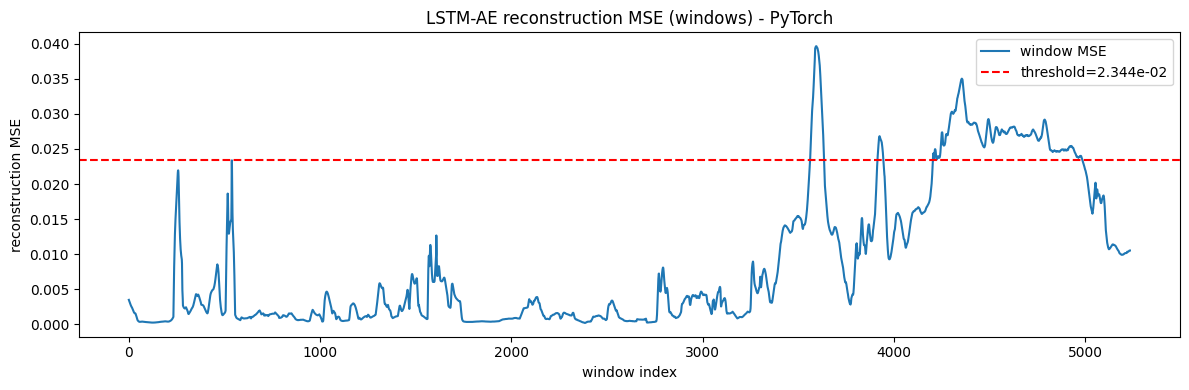

Step 10 done. All outputs saved and plotted.


In [ ]:
# Step 10: detect anomalies and create simple report
n_windows = len(mse_test)
window_starts = np.arange(0, n_windows)                 # window i covers rows [i : i+TIMESTEPS-1]
window_ends = window_starts + TIMESTEPS - 1

is_anom = mse_test > threshold
results = pd.DataFrame({
    "window_index": window_starts,
    "window_start_row": window_starts,
    "window_end_row": window_ends,
    "reconstruction_mse": mse_test,
    "is_anomaly": is_anom.astype(int)
})

# optionally attach center timestamp if present in df_fault
ts_col = None
for cand in ["timestamp","time","ts","Clock:offsetTime","TimeStamp"]:
    if cand in df_fault.columns:
        ts_col = cand; break
if ts_col:
    if not np.issubdtype(df_fault[ts_col].dtype, np.number):
        try:
            df_fault[ts_col] = pd.to_datetime(df_fault[ts_col]).astype('int64') // 10**6
        except:
            pass
    results["time_center_ms"] = [int(df_fault[ts_col].iloc[i + TIMESTEPS//2]) for i in window_starts]

# merge consecutive anomalous windows into segments
segments = []
in_seg = False
for idx, row in results.iterrows():
    if row["is_anomaly"] == 1 and not in_seg:
        seg_s = int(row["window_start_row"]); in_seg = True; seg_e = int(row["window_end_row"])
    elif row["is_anomaly"] == 1 and in_seg:
        seg_e = int(row["window_end_row"])
    elif row["is_anomaly"] == 0 and in_seg:
        segments.append((seg_s, seg_e)); in_seg = False
if in_seg:
    segments.append((seg_s, seg_e))

print("Detected anomaly segments (row_start, row_end):", segments)

# per-feature MSE per window (n_windows, n_features)
# compute reconstructons per-window in batches to get per-feature error
def per_feature_errors(model, data_array):
    ds = TimeSeriesDataset(data_array)
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False)
    per_feat = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(device)
            out = model(xb)
            # per-sample, per-feature MSE averaged across timesteps:
            # ((T,d) error squared).mean over T -> (batch,d)
            err = torch.mean((xb - out)**2, dim=1).cpu().numpy()  # (batch, d)
            per_feat.append(err)
    return np.vstack(per_feat)  # (n_windows, d)

pf_errors = per_feature_errors(model, X_test)

# For each segment compute mean per-feature error and rank features
feature_reports = []
for (s_row, e_row) in segments:
    # map row indices to window indices roughly (start windows covering those rows)
    win_start = max(0, s_row)
    win_end = min(n_windows-1, e_row - TIMESTEPS + 1)
    if win_end < win_start:
        win_end = win_start
    agg = pf_errors[win_start:win_end+1].mean(axis=0)
    ranking = sorted(zip(FEATURES, agg), key=lambda x: x[1], reverse=True)
    feature_reports.append({
        "segment_start_row": int(s_row),
        "segment_end_row": int(e_row),
        "top_features": "; ".join([f"{f}:{val:.3e}" for f,val in ranking[:3]])
    })

report_df = pd.DataFrame(feature_reports)
report_df.to_csv(os.path.join(OUT_DIR, "pytorch_rootcause_report.csv"), index=False)
results.to_csv(os.path.join(OUT_DIR, "pytorch_windowed_results.csv"), index=False)
print("Saved reports to:", OUT_DIR)

# plot reconstruction MSE vs window index
plt.figure(figsize=(12,4))
plt.plot(results["window_index"], results["reconstruction_mse"], label="window MSE")
plt.axhline(threshold, color='r', linestyle='--', label=f"threshold={threshold:.3e}")
plt.xlabel("window index")
plt.ylabel("reconstruction MSE")
plt.title("LSTM-AE reconstruction MSE (windows) - PyTorch")
plt.legend()
plt.tight_layout()
plt.show()

print("Step 10 done. All outputs saved and plotted.")


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
import torch
from torch.utils.data import DataLoader

# --------------------------
# Example SUBSYSTEM_MAP - adapt names to your FEATURES exactly
# Updated to reflect only features present in the global FEATURES list
# --------------------------
SUBSYSTEM_MAP = {
    "IMU": [
        "IMU_ATTI(0):accelX", "IMU_ATTI(0):accelY", "IMU_ATTI(0):accelZ",
        "IMU_ATTI(0):Longitude", "IMU_ATTI(0):roll:C", "IMU_ATTI(0):pitch:C", "IMU_ATTI(0):yaw:C",
        "IMU_ATTI(0):press:D" # Assuming pressure could be IMU related
    ],
    # No direct 'Motors' features in the current FEATURES list, but keep the entry
    "Motors": [],
    "RC": [], # No RC specific features in the current FEATURES list
    "GPS": [
        "IMU_ATTI(0):Longitude", "IMU_ATTI(0):Latitude", "IMU_ATTI(0):alti:D",
        "IMU_ATTI(0):relativeHeight:C", "IMU_ATTI(0):numSats",
        "IMU_ATTI(0):roll:C", "IMU_ATTI(0):pitch:C", "IMU_ATTI(0):yaw:C"
    ],
    "Battery": [] # No battery specific features in the current FEATURES list
}

# Filter SUBSYSTEM_MAP to only include features actually present in the global FEATURES list
# This makes the map robust to changes in FEATURES
filtered_subsystem_map = {}
for subsystem, features_list in SUBSYSTEM_MAP.items():
    filtered_subsystem_map[subsystem] = [f for f in features_list if f in FEATURES]
SUBSYSTEM_MAP = filtered_subsystem_map

# human labels for final messages
HUMAN_LABEL = {
    "Motors": "Engine failure",
    "IMU": "IMU / Accelerometer failure",
    "RC": "Radio controller fault",
    "GPS": "GPS spoofing / GPS failure",
    "Battery": "Power / Battery issue",
    "UNKNOWN": "Unknown subsystem"
}

# Build reverse lookup: feature -> subsystem(s)
feature_to_subsystems = {}
for s, feats in SUBSYSTEM_MAP.items():
    for f in feats:
        feature_to_subsystems.setdefault(f, []).append(s)

# --------------------------
# 1) Utilities: per-feature MSE and normalization
# --------------------------
def per_feature_mse(orig_windows, recon_windows):
    """Return (n_windows, n_features) of mean squared error per feature (avg over timesteps)."""
    se = (orig_windows - recon_windows) ** 2
    return se.mean(axis=1)

def normalize_feature_scores(mse_pf, method="percentile"):
    """
    mse_pf: (n_windows, n_features)
    method: 'zscore' or 'percentile' - returns normalized scores in [0,1] (higher = more anomalous)
    """
    if method == "zscore":
        # compute zscore per feature across windows, then map to 0..1 via sigmoid-like transform
        zs = zscore(mse_pf, axis=0, nan_policy='omit')
        # map zscore to 0..1 using scaled logistic-ish transform
        norm = 1 / (1 + np.exp(-0.8 * (zs - 1.0)))  # shift so that z>1 -> >0.5
        return np.nan_to_num(norm)
    else:
        # percentile: for each feature, compute percentile rank of each window's mse
        n, f = mse_pf.shape
        norm = np.zeros_like(mse_pf, dtype=float)
        for j in range(f):
            col = mse_pf[:, j]
            # handle constant col
            if np.allclose(col, col[0]):
                norm[:, j] = 0.0
            else:
                ranks = pd.Series(col).rank(method="average", pct=True).values
                norm[:, j] = ranks  # 0..1
        return norm

# --------------------------
# 2) Subsystem aggregation & ranking
# --------------------------
def subsystem_scores_from_feature_norms(norm_pf, feature_names, feature_to_subsystems, agg="sum"):
    """
    norm_pf: (n_windows, n_features) normalized per-feature anomaly scores [0..1]
    returns DataFrame (n_windows x subsystems) with aggregated scores (higher = more anomalous)
    """
    rows = []
    for w in range(norm_pf.shape[0]):
        feat_vals = dict(zip(feature_names, norm_pf[w]))
        subs = {}
        for feat, val in feat_vals.items():
            subsys_list = feature_to_subsystems.get(feat, ["UNKNOWN"])
            for s in subsys_list:
                subs.setdefault(s, 0.0)
                subs[s] += float(val) if agg == "sum" else float(val) / len(subsys_list)
        rows.append(subs)
    df = pd.DataFrame(rows).fillna(0.0)
    # normalize each row to 0..1 by dividing by max (avoid divide-by-zero)
    if df.shape[1] > 0:
        df_norm = df.div(df.max(axis=1).replace(0, 1), axis=0)
    else:
        df_norm = df
    return df_norm

# --------------------------
# 3) Specific detectors (accelerometer loss, GPS spoofing heuristics, motor anomaly heuristics)
# --------------------------
def detect_accel_loss_single(window_orig, accel_feature_names, var_threshold=1e-6, flat_range_threshold=1e-4):
    """Return True if ANY accel feature shows NaNs or near-constant values in this window."""
    idxs = [FEATURES.index(f) for f in accel_feature_names if f in FEATURES]
    if not idxs:
        return False
    for i in idxs:
        col = window_orig[:, i]
        if np.isnan(col).any() or np.isinf(col).any():
            return True
        if np.nanvar(col) < var_threshold:
            return True
        if (np.nanmax(col) - np.nanmin(col)) < flat_range_threshold:
            return True
    return False

def detect_gps_spoofing_single(window_orig, gps_names, jump_threshold_m=50.0, speed_unrealistic=50.0):
    """
    Heuristics for GPS spoofing:
      - very large jump between consecutive lat/lon (approx distance > jump_threshold_m),
      - unrealistic speed in GPS speed column (> speed_unrealistic m/s),
      - repeated exact same lat/lon for long (could be stuck) - treat separately as failure, not spoofing.
    This is heuristic: tune thresholds to your dataset scale.
    """
    # quick helper: haversine distance in meters
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371000.0
        phi1 = np.deg2rad(lat1); phi2 = np.deg2rad(lat2)
        dphi = np.deg2rad(lat2 - lat1); dlambda = np.deg2rad(lon2 - lon1)
        a = np.sin(dphi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2.0)**2
        return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    # find indices
    lat_name = next((f for f in gps_names if "lat" in f.lower()), None)
    lon_name = next((f for f in gps_names if "lon" in f.lower() or "long" in f.lower()), None)
    speed_name = next((f for f in gps_names if "speed" in f.lower()), None)

    if lat_name is None or lon_name is None:
        return False  # can't check leaps without lat/lon

    if lat_name not in FEATURES or lon_name not in FEATURES:
        return False

    lat = window_orig[:, FEATURES.index(lat_name)]
    lon = window_orig[:, FEATURES.index(lon_name)]

    # NaN or inf -> treat as GPS failure
    if np.isnan(lat).any() or np.isnan(lon).any():
        return True

    # consecutive big jumps
    diffs = []
    for i in range(1, len(lat)):
        try:
            d = haversine(lat[i-1], lon[i-1], lat[i], lon[i])
            diffs.append(d)
        except:
            diffs.append(0.0)
    if len(diffs) > 0 and max(diffs) > jump_threshold_m:
        return True

    # unrealistic speed check (if speed available)
    if speed_name and speed_name in FEATURES:
        sp = window_orig[:, FEATURES.index(speed_name)]
        if np.nanmax(sp) > speed_unrealistic:
            return True

    return False

def detect_motor_failure_single(window_orig, motor_feature_names, rpm_jump_threshold=1000.0, current_spike_threshold=10.0):
    """
    Heuristic: large rpm mismatch or sudden spikes in motor current or rpm.
    Tune thresholds depending on your motor data scale.
    """
    idxs_rpm = [FEATURES.index(f) for f in motor_feature_names if f in FEATURES and "rpm" in f.lower()]
    idxs_cur = [FEATURES.index(f) for f in motor_feature_names if f in FEATURES and ("current" in f.lower() or "amp" in f.lower())]
    # check rpm jumps
    for i in idxs_rpm:
        col = window_orig[:, i]
        if np.isnan(col).any():
            continue
        if np.nanmax(np.abs(np.diff(col))) > rpm_jump_threshold:
            return True
    # check current spikes
    for i in idxs_cur:
        col = window_orig[:, i]
        if np.nanmax(col) > current_spike_threshold:
            return True
    return False

# --------------------------
# 4) Main decision function to build final root-cause predictions
# --------------------------
def predict_root_causes_multi(orig_windows, recon_windows, window_report_df,
                              feature_names=FEATURES,
                              feature_to_subsystems=feature_to_subsystems,
                              accel_feature_keywords=("acc", "accel"),
                              gps_feature_keywords=("gps", "lat", "lon", "speed", "alti", "height", "numSats"), # Added relevant keywords
                              motor_feature_keywords=("motor", "rpm", "current"),
                              prefer_motor_when_cooccurs=True,
                              norm_method="percentile",
                              primary_threshold=0.35,
                              secondary_threshold=0.15):
    """
    Returns annotated_df with predictions:
      - pred_primary_subsystem
      - pred_secondary_subsystems (list)
      - root_cause_text (human readable)
      - root_cause_confidence (primary normalized score)
      - explanatory_flags (accel_loss, gps_spoof, motor_detected)
    primary_threshold: minimum normalized subsystem score (0..1) to be considered primary
    secondary_threshold: threshold for secondary causes
    """
    # 1) get per-feature MSE and normalize
    mse_pf = per_feature_mse(orig_windows, recon_windows)  # (n_windows, n_features)
    norm_pf = normalize_feature_scores(mse_pf, method=norm_method)  # (n_windows, n_features)

    # 2) aggregate into subsystem scores
    subs_df = subsystem_scores_from_feature_norms(norm_pf, feature_names, feature_to_subsystems, agg="sum")
    # ensure same index ordering: rows correspond to windows in order passed

    # 3) find feature groups (lists) for detectors
    ACCEL_FEATURES = [f for f in feature_names if any(k in f.lower() for k in accel_feature_keywords)]
    GPS_FEATURES = [f for f in feature_names if any(k in f.lower() for k in gps_feature_keywords)]
    MOTOR_FEATURES = [f for f in feature_names if any(k in f.lower() for k in motor_feature_keywords)]

    results_list = [] # Renamed to avoid confusion with the global 'results' DataFrame
    for i in range(len(subs_df)):
        row = subs_df.iloc[i].copy()
        # convert to descending ranked series
        ranked = row.sort_values(ascending=False)
        # normalized across subsystems (sum->1) for probability-like interpretation
        total = row.sum()
        if total <= 0:
            norm_row = row * 0.0
        else:
            norm_row = row / total

        # detectors
        accel_loss = detect_accel_loss_single(orig_windows[i], ACCEL_FEATURES)
        gps_spoof = detect_gps_spoofing_single(orig_windows[i], GPS_FEATURES)
        motor_fail = detect_motor_failure_single(orig_windows[i], MOTOR_FEATURES)

        # identify primary candidate(s) by numeric score
        primary_candidate = ranked.index[0] if len(ranked) > 0 else "UNKNOWN"
        primary_score = float(ranked.iloc[0]) if len(ranked)>0 else 0.0

        # propose secondary candidates above threshold
        secondaries = list(ranked[ranked >= secondary_threshold].index)
        # remove primary if present
        secondaries = [s for s in secondaries if s != primary_candidate]

        # rule adjustments
        # if motor+IMU both anomalous and prefer_motor_when_cooccurs -> pick Motors as primary
        if prefer_motor_when_cooccurs and "Motors" in row.index and "IMU" in row.index:
            if row["Motors"] > 0 and row["IMU"] > 0:
                # prefer motors even if motors score is slightly less than IMU
                primary_candidate = "Motors"
                primary_score = float(row["Motors"])
                if "IMU" in secondaries:
                    # ensure IMU remains secondary if notable
                    pass

        # if detectors say GPS spoofing strongly but GPS didn't top the numeric score:
        if gps_spoof and primary_candidate != "GPS":
            # if GPS normalized score is fairly high (>0.2) or gps_spoof heuristic triggered, add it to secondaries
            gps_score = float(row.get("GPS", 0.0))
            if gps_score >= secondary_threshold or gps_spoof:
                if "GPS" not in secondaries and primary_candidate != "GPS":
                    secondaries.insert(0, "GPS")

        # If accel loss detected and IMU is not primary, add it as secondary
        if accel_loss:
            imu_score = float(row.get("IMU", 0.0))
            if "IMU" not in secondaries and primary_candidate != "IMU":
                if imu_score >= (secondary_threshold/2) or accel_loss:
                    secondaries.insert(0, "IMU")

        # Format final human readable label
        primary_label = HUMAN_LABEL.get(primary_candidate, HUMAN_LABEL["UNKNOWN"])
        secondary_labels = [HUMAN_LABEL.get(s, s) for s in secondaries]

        # Compose textual explanation
        explanation = f"Primary: {primary_label} (score {primary_score:.2f})"
        if len(secondary_labels) > 0:
            explanation += f"; Secondary: {', '.join(secondary_labels)}"
        # append detector notes
        notes = []
        if accel_loss: notes.append("accelerometer loss detected")
        if motor_fail: notes.append("motor abnormality detected (spike/mismatch)")
        if gps_spoof: notes.append("gps spoofing/failure heuristics triggered")
        if notes:
            explanation += " [" + "; ".join(notes) + "]"

        results_list.append({
            "pred_primary_subsystem": primary_candidate,
            "pred_primary_confidence": float(norm_row.get(primary_candidate, 0.0)),
            "pred_secondary_subsystems": secondaries,
            "pred_secondary_confidences": {s: float(norm_row.get(s, 0.0)) for s in secondaries},
            "accel_loss_detected": accel_loss,
            "motor_flag": motor_fail,
            "gps_flag": gps_spoof,
            "root_cause_text": explanation,
            "subsystem_scores_raw": row.to_dict(),
            "subsystem_scores_normalized": norm_row.to_dict()
        })

    # build result DF and attach to window_report_df (assume same ordering)
    annotated = window_report_df.reset_index(drop=True).copy()
    if len(results_list) != len(annotated):
        raise ValueError("Length mismatch between results and provided window_report_df. Ensure you passed only windows that match rows.")
    for k in results_list[0].keys():
        annotated[k] = [r[k] for r in results_list]
    return annotated

# --------------------------
# Example usage (annotating only anomaly windows)
# --------------------------
# First, calculate recon_test_windows
model.eval()
all_reconstructions = []
test_dataset = TimeSeriesDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        out = model(xb)
        all_reconstructions.append(out.cpu().numpy())
recon_test_windows = np.vstack(all_reconstructions)

anomalous_windows_df = results[results["is_anomaly"] == 1].reset_index(drop=True)
if anomalous_windows_df.shape[0] == 0:
    print("No anomalies to annotate.")
else:
    anomaly_idxs = anomalous_windows_df["window_index"].values  # indices into X_test
    orig_anom = X_test[anomaly_idxs]          # shape (n_anom, timesteps, n_features)
    recon_anom = recon_test_windows[anomaly_idxs]

    annotated = predict_root_causes_multi(
        orig_windows=orig_anom,
        recon_windows=recon_anom,
        window_report_df=anomalous_windows_df,
        feature_names=FEATURES,
        feature_to_subsystems=feature_to_subsystems,
        prefer_motor_when_cooccurs=True,
        norm_method="percentile",
        primary_threshold=0.35,
        secondary_threshold=0.15
    )

    # Print brief output for each anomaly
    for _, r in annotated.iterrows():
        print(f"Window {r['window_index']}: {r['root_cause_text']}")

Window 3563: Primary: GPS spoofing / GPS failure (score 1.00); Secondary: IMU / Accelerometer failure
Window 3564: Primary: GPS spoofing / GPS failure (score 1.00); Secondary: IMU / Accelerometer failure
Window 3565: Primary: GPS spoofing / GPS failure (score 1.00); Secondary: IMU / Accelerometer failure
Window 3566: Primary: GPS spoofing / GPS failure (score 1.00); Secondary: IMU / Accelerometer failure
Window 3567: Primary: GPS spoofing / GPS failure (score 1.00); Secondary: IMU / Accelerometer failure
Window 3568: Primary: GPS spoofing / GPS failure (score 1.00); Secondary: IMU / Accelerometer failure
Window 3569: Primary: GPS spoofing / GPS failure (score 1.00); Secondary: IMU / Accelerometer failure
Window 3570: Primary: GPS spoofing / GPS failure (score 1.00); Secondary: IMU / Accelerometer failure
Window 3571: Primary: GPS spoofing / GPS failure (score 1.00); Secondary: IMU / Accelerometer failure
Window 3572: Primary: GPS spoofing / GPS failure (score 1.00); Secondary: IMU / Ac

In [ ]:
# ---------- Aggregate anomalous windows into failure events & produce event-level root cause ----------
import numpy as np
import pandas as pd
from collections import defaultdict

def group_consecutive_indices(indices, max_gap=1):
    """
    Group a sorted list/array of integer indices into runs where gaps <= max_gap.
    Example: [1,2,3,6,7] with max_gap=1 -> [[1,2,3],[6,7]]
    """
    if len(indices) == 0:
        return []
    indices = np.sort(np.unique(np.asarray(indices)))
    groups = []
    cur = [int(indices[0])]
    for idx in indices[1:]:
        if int(idx) - cur[-1] <= max_gap:
            cur.append(int(idx))
        else:
            groups.append(cur)
            cur = [int(idx)]
    groups.append(cur)
    return groups

def aggregate_event_scores(window_idxs, per_window_mse_pf, feature_names, feature_to_subsystems,
                           agg_method="mean"):
    """
    Aggregate per-feature MSE across windows in the event then map to subsystem scores.
    per_window_mse_pf: (n_all_windows, n_features) array (MSE per-feature per-window).
    window_idxs: list of window indices included in this event (indices into per_window_mse_pf).
    agg_method: "mean", "max", or "sum" -> how to combine per-window per-feature MSE.
    Returns: subsystem_raw_scores (dict), subsystem_norm_scores (dict), per_feature_agg (1d array)
    """
    if len(window_idxs) == 0:
        return {}, {}, np.zeros(len(feature_names))
    sel = per_window_mse_pf[window_idxs, :]  # shape (n_event_windows, n_features)
    if agg_method == "mean":
        feat_agg = np.nanmean(sel, axis=0)
    elif agg_method == "max":
        feat_agg = np.nanmax(sel, axis=0)
    elif agg_method == "sum":
        feat_agg = np.nansum(sel, axis=0)
    else:
        raise ValueError("agg_method must be 'mean','max' or 'sum'")

    # Map per-feature agg -> subsystems
    subs_raw = defaultdict(float)
    for f_idx, val in enumerate(feat_agg):
        fname = feature_names[f_idx]
        subs = feature_to_subsystems.get(fname, ["UNKNOWN"])
        for s in subs:
            subs_raw[s] += float(val)
    # normalize subsystem scores to sum->1 for probability-like interpretation if total>0
    total = sum(subs_raw.values())
    if total > 0:
        subs_norm = {k: v / total for k, v in subs_raw.items()}
    else:
        subs_norm = {k: 0.0 for k in subs_raw.keys()}
    return dict(subs_raw), subs_norm, feat_agg

def majority_flag(flag_list, rule="any", fraction=0.5):
    """
    Combine boolean flags across windows in an event.
    rule: "any" -> True if any window True
          "all" -> True if all windows True
          "frac" -> True if fraction of True >= fraction
    """
    if len(flag_list) == 0:
        return False
    if rule == "any":
        return any(flag_list)
    if rule == "all":
        return all(flag_list)
    if rule == "frac":
        return (sum(1 for v in flag_list if v) / len(flag_list)) >= fraction
    return any(flag_list)

def build_failure_events_df(annotated_windows_df,
                            per_window_mse_pf,
                            feature_names,
                            feature_to_subsystems,
                            X_windows=None,
                            recon_windows=None,
                            agg_method="mean",
                            max_gap_windows=1,
                            flag_rule="any",
                            prefer_motor_over_imu=True,
                            secondary_cutoff=0.10):
    """
    annotated_windows_df: DataFrame of anomalous windows (rows correspond to windows listed).
      Required columns: window_index (index into global X_test_windows), window_start_row, window_end_row
      May also include accel_loss_detected, motor_flag, gps_flag — if present we'll use them; if not, we can derive flags using X_windows
    per_window_mse_pf: full array of per-window per-feature MSE (n_windows_total, n_features)
    X_windows, recon_windows: optional arrays aligned with global window indexes for recomputing detectors if needed
    Returns: events_df (one row per grouped event)
    """
    # Ensure annotated_windows_df sorted by window_index
    ann = annotated_windows_df.sort_values(by="window_index").reset_index(drop=True)
    window_indices = ann["window_index"].astype(int).values
    grouped_runs = group_consecutive_indices(window_indices, max_gap=max_gap_windows)

    events = []
    event_id = 0
    for run in grouped_runs:
        event_id += 1
        # run is list of window indices (global indices)
        # slice rows in annotated_windows_df corresponding to these windows
        rows_mask = ann["window_index"].isin(run)
        rows = ann[rows_mask].reset_index(drop=True)

        # aggregate per-window results into event-level:
        subs_raw, subs_norm, feat_agg = aggregate_event_scores(run, per_window_mse_pf,
                                                               feature_names, feature_to_subsystems,
                                                               agg_method=agg_method)

        # detectors: if annotated windows have flags, use them; else compute from provided X_windows slice
        accel_flags = list(rows.get("accel_loss_detected", pd.Series([False]*len(rows))))
        motor_flags = list(rows.get("motor_flag", pd.Series([False]*len(rows))))
        gps_flags = list(rows.get("gps_flag", pd.Series([False]*len(rows))))

        # if flags missing or all False and X_windows provided, compute detectors across windows and use majority rule
        if (not any(accel_flags) and X_windows is not None):
            # attempt to recompute accel flags from X_windows
            accel_idxs = [i for i in range(len(run)) if len(X_windows) > 0]  # placeholder
            accel_flags = []
            for widx in run:
                try:
                    accel_flags.append(detect_accel_loss_single(X_windows[widx], [f for f in feature_names if "accel" in f.lower()]))
                except Exception:
                    accel_flags.append(False)
        if (not any(motor_flags) and X_windows is not None):
            motor_flags = []
            motor_speed_feats = [f for f in feature_names if "Motor:Speed" in f]
            motor_curr_feats = [f for f in feature_names if "Motor:Current" in f]
            for widx in run:
                try:
                    motor_flags.append(detect_motor_failure_single(X_windows[widx], MOTOR_FEATURES))
                except Exception:
                    motor_flags.append(False)
        if (not any(gps_flags) and X_windows is not None):
            gps_flags = []
            for widx in run:
                try:
                    gps_flags.append(detect_gps_spoofing_single(X_windows[widx], GPS_FEATURES))
                except Exception:
                    gps_flags.append(False)

        accel_event = majority_flag(accel_flags, rule=flag_rule)
        motor_event = majority_flag(motor_flags, rule=flag_rule)
        gps_event = majority_flag(gps_flags, rule=flag_rule)

        # Primary subsystem selection: highest raw score (tie-breaker by prefer_motor_over_imu)
        if len(subs_raw) == 0:
            primary_sub = "UNKNOWN"
            primary_conf = 0.0
        else:
            # sort by raw score descending
            sorted_subs = sorted(subs_raw.items(), key=lambda x: x[1], reverse=True)
            primary_sub = sorted_subs[0][0]
            primary_conf = subs_norm.get(primary_sub, 0.0)
            # prefer motor if co-occur and asked
            if prefer_motor_over_imu and "Motors" in subs_raw and "IMU" in subs_raw:
                if subs_raw["Motors"] > 0 and subs_raw["IMU"] > 0:
                    primary_sub = "Motors"
                    primary_conf = subs_norm.get("Motors", primary_conf)

        # build secondaries: any subsystem with normalized score >= secondary_cutoff and not the primary
        secondaries = [k for k,v in subs_norm.items() if (v >= secondary_cutoff and k != primary_sub)]
        # ensure GPS/IMU included if detector flags are True but not present due to mapping
        if gps_event and "GPS" not in secondaries and primary_sub != "GPS":
            secondaries.insert(0, "GPS")
        if accel_event and "IMU" not in secondaries and primary_sub != "IMU":
            secondaries.insert(0, "IMU")
        if motor_event and "Motors" not in secondaries and primary_sub != "Motors":
            secondaries.insert(0, "Motors")

        # Map to human-readable labels
        primary_label = HUMAN_LABEL.get(primary_sub, HUMAN_LABEL.get("UNKNOWN", primary_sub))
        secondary_labels = [HUMAN_LABEL.get(s, s) for s in secondaries]

        # get start/end window and rows (if present)
        start_window = int(run[0])
        end_window = int(run[-1])
        # try to retrieve row indexes from rows DataFrame
        start_row = int(rows["window_start_row"].iloc[0]) if "window_start_row" in rows.columns else None
        end_row = int(rows["window_end_row"].iloc[-1]) if "window_end_row" in rows.columns else None

        notes = []
        if accel_event: notes.append("accelerometer loss majority")
        if motor_event: notes.append("motor abnormality majority")
        if gps_event: notes.append("gps spoof heuristics majority")

        events.append({
            "event_id": event_id,
            "start_window": start_window,
            "end_window": end_window,
            "start_row": start_row,
            "end_row": end_row,
            "num_windows": len(run),
            "primary_subsystem": primary_sub,
            "primary_label": primary_label,
            "primary_confidence": float(primary_conf),
            "secondary_subsystems": secondary_labels,
            "secondary_labels": secondary_labels,
            "notes": "; ".join(notes) if notes else "",
            "subsystem_scores_raw": dict(subs_raw),
            "subsystem_scores_normalized": dict(subs_norm),
            "feature_scores_agg": feat_agg.tolist()
        })

    events_df = pd.DataFrame(events)
    return events_df

# ---------------------------
# Example usage: build events from annotated anomalies
# ---------------------------
# Precondition: you have annotated (per-window) DataFrame (call it annotated) containing anomaly windows.
# Also you must have per-window per-feature MSE array per_window_mse_pf (n_windows_total x n_features).
# If you don't have per_window_mse_pf already, compute it:
# per_window_mse_pf = per_feature_mse(X_test_windows_all, recon_test_windows_all)

# Parameters you can tweak:
MAX_GAP_WINDOWS = 2         # merge anomaly windows separated by <= 2 windows into one event
AGG_METHOD = "mean"         # 'mean'|'max'|'sum' when aggregating per-feature MSE across event
FLAG_RULE = "any"           # 'any'|'all'|'frac' to combine window-level flags into event-level flags
SECONDARY_CUTOFF = 0.12     # normalized subsystem score to consider as secondary
PREFER_MOTOR = True

# Build the events DataFrame:
# Assume annotated is the per-window anomaly DataFrame (only anomaly windows), and
# per_window_mse_pf is the full MSE matrix with same indexing as window_index
events_df = build_failure_events_df(
    annotated_windows_df=annotated,
    per_window_mse_pf=pf_errors,   # Use the already computed pf_errors
    feature_names=FEATURES,
    feature_to_subsystems=feature_to_subsystems,
    X_windows=X_test,
    recon_windows=recon_test_windows,
    agg_method=AGG_METHOD,
    max_gap_windows=MAX_GAP_WINDOWS,
    flag_rule=FLAG_RULE,
    prefer_motor_over_imu=PREFER_MOTOR,
    secondary_cutoff=SECONDARY_CUTOFF
)

# Print succinct event summaries
if events_df.shape[0] == 0:
    print("No failure events found.")
else:
    for _, e in events_df.iterrows():
        rng = f"windows {e['start_window']}–{e['end_window']} (rows {e['start_row']}–{e['end_row']})"
        secs = ", ".join(e['secondary_labels']) if e['secondary_labels'] else "None"
        print(f"Event {e['event_id']}: {rng}  → Primary: {e['primary_label']} (conf {e['primary_confidence']:.2f}); Secondary: {secs}; Notes: {e['notes']}")

Event 1: windows 3563–3635 (rows 3563–3684)  → Primary: GPS spoofing / GPS failure (conf 0.57); Secondary: IMU / Accelerometer failure; Notes: 
Event 2: windows 3915–3945 (rows 3915–3994)  → Primary: GPS spoofing / GPS failure (conf 0.61); Secondary: IMU / Accelerometer failure; Notes: gps spoof heuristics majority
Event 3: windows 4205–4985 (rows 4205–5034)  → Primary: GPS spoofing / GPS failure (conf 0.62); Secondary: IMU / Accelerometer failure; Notes: gps spoof heuristics majority
